# IUI - SPC Annotated Data Exploration
### 10/11/2022

Measure and make plots from the cleaned up SPC data. 

author: E. Orenstein (eorenstein@mbari.org)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
from tqdm import notebook
import sys
import cv2
from multiprocessing.pool import ThreadPool, Pool
from multiprocessing import Process, Queue, cpu_count
from sklearn import preprocessing
from datetime import datetime

sys.path.append(r'C:\Users\spc\software\Dual-Mag-Data')
from scripts.proc_directory import threaded_roi_proc
from libs.rois import ROI

Get the list of directories to process

In [2]:
ptfs = glob.glob(os.path.join(r'D:\spc_annotations_101122', '*'))
ptfs = [line for line in ptfs if os.path.isdir(line)]

## First cut

First cut of processing with computing features. This traverses the directories and gets information about the average hieght, width, and area of each ROI. Note: **this is not computed from the binary mask** so the values are purely based on the dimensions of the bounding boxes. 

In [3]:
out = {}
for ptf in notebook.tqdm(ptfs):
    imgs = glob.glob(os.path.join(ptf, '*.jpeg'))
    tmp = {'height': [],
    'width': [],
    'area': [],
    'num_raw': 0,
    'num_mask': 0
    }
    for img in imgs:
        im = Image.open(img)
        tmp['height'].append(im.height)
        tmp['width'].append(im.width)
        tmp['area'].append(im.width*im.height)
        if 'rawcolor' in img:
            tmp['num_raw'] += 1
        else:
            tmp['num_mask'] += 1

    out[os.path.basename(ptf)] = {'mean_height': np.mean(np.asarray(tmp['height'])),
    'max_height': np.max(np.asarray(tmp['height'])),
    'min_height': np.min(np.asarray(tmp['height'])),
    'mean_width': np.mean(np.asarray(tmp['width'])),
    'max_width': np.max(np.asarray(tmp['width'])),
    'min_width': np.min(np.asarray(tmp['width'])),
    'mean_area': np.mean(np.asarray(tmp['area'])),
    'max_area': np.max(np.asarray(tmp['area'])),
    'min_area': np.min(np.asarray(tmp['area'])),
    'num_raw': tmp['num_raw'],
    'num_mask': tmp['num_mask']
    }

df = pd.DataFrame(out)
df = df.T
df

  0%|          | 0/17 [00:00<?, ?it/s]

,mean_height,max_height,min_height,mean_width,max_width,min_width,mean_area,max_area,min_area,num_raw,num_mask
ceratium,78.796813,157.0,28.0,77.545817,180.0,28.0,6106.055777,21888.0,1008.0,251.0,0.0
chaetoceros,126.979689,456.0,28.0,125.356033,392.0,32.0,17263.551971,176928.0,1792.0,837.0,0.0
Cnidaria,52.009174,312.0,24.0,52.618611,292.0,24.0,3838.988204,91104.0,672.0,763.0,0.0
copepoda,142.829114,632.0,28.0,136.337975,503.0,36.0,21188.483544,281680.0,2240.0,1580.0,0.0
Diatoms_round_chains,100.230126,360.0,32.0,98.559275,324.0,29.0,10616.602510,94608.0,1920.0,717.0,0.0
Diatoms_single_cells,107.502140,940.0,12.0,93.461484,1084.0,12.0,14522.607703,740720.0,672.0,1402.0,0.0
Diatoms_spirals,125.778471,431.0,32.0,129.095164,656.0,28.0,18309.191888,127576.0,1792.0,641.0,0.0
Diatoms_straight_chains,140.157609,468.0,16.0,125.663043,516.0,20.0,20102.326087,175968.0,832.0,736.0,0.0
Marine_snow_POC,89.065753,432.0,24.0,90.716438,360.0,24.0,8994.083562,126144.0,864.0,730.0,0.0
mollusca,121.377005,612.0,40.0,121.668449,732.0,44.0,18553.379679,447984.0,2240.0,374.0,0.0


## Load annotations

Compute the image features if needed. The cell below uses the same feature extraction code from SPCconvert. 

In [17]:
### RUN THIS CELL IF YOU NEED TO EXTRACT FEATURES ####

# probs = []
# feat_out = []
# for ptf in notebook.tqdm(ptfs, desc='labels'):

#     # get list of images
#     imgs = glob.glob(os.path.join(ptf, '*.jpeg'))

#     # compute features
#     raw_rois = []
#     out = {}
#     ct = 0
#     for roi in notebook.tqdm(imgs, desc=f'imgs in {os.path.basename(ptf)}'):
#         try:
#             tmp = ROI(os.path.split(roi)[0], os.path.split(roi)[1], bayer_pattern=None)
#         except IndexError:
#             #print(f'problem with roi {roi}')
#             ct += 1
#             continue
#         if tmp.loaded:
#             raw_rois.append(tmp)
    
#     print(f'Missing {ct} in {os.path.basename(ptf)}')

#     for ii in range(0, len(raw_rois)):
#         raw_rois[ii].process(save_to_disk=False)

#         # make the output dictionary ignoring the full images
#         try:
#             del raw_rois[ii].features['binary']
#             del raw_rois[ii].features['image']
#             del raw_rois[ii].features['rawcolor']
#             tmp = raw_rois[ii].features
#             tmp['timestamp'] = raw_rois[ii].timestamp
#             tmp['timestring'] = raw_rois[ii].timestring
#             tmp['concept'] = os.path.basename(ptf)
#             out[raw_rois[ii].filename] = tmp
#         except KeyError:
#             probs.append(imgs[ii])
#             continue

#     df = pd.DataFrame(out)
#     df = df.T
#     #df.to_csv(os.path.join(ptf, 'img_features.csv'))
#     feat_out.append(df)

# df = pd.concat(feat_out)
# df.to_csv(r'D:\spc_annotations_101122\img_features.csv')

labels:   0%|          | 0/17 [00:00<?, ?it/s]

imgs in ceratium:   0%|          | 0/251 [00:00<?, ?it/s]

Missing 0 in ceratium


imgs in chaetoceros:   0%|          | 0/837 [00:00<?, ?it/s]

Missing 0 in chaetoceros


imgs in Cnidaria:   0%|          | 0/763 [00:00<?, ?it/s]

Missing 0 in Cnidaria


imgs in copepoda:   0%|          | 0/1580 [00:00<?, ?it/s]

Missing 0 in copepoda


imgs in Diatoms_round_chains:   0%|          | 0/717 [00:00<?, ?it/s]

Missing 0 in Diatoms_round_chains


imgs in Diatoms_single_cells:   0%|          | 0/1402 [00:00<?, ?it/s]

Missing 0 in Diatoms_single_cells


imgs in Diatoms_spirals:   0%|          | 0/641 [00:00<?, ?it/s]

Missing 0 in Diatoms_spirals


imgs in Diatoms_straight_chains:   0%|          | 0/736 [00:00<?, ?it/s]

Missing 0 in Diatoms_straight_chains


imgs in Marine_snow_POC:   0%|          | 0/730 [00:00<?, ?it/s]

Missing 0 in Marine_snow_POC


imgs in mollusca:   0%|          | 0/374 [00:00<?, ?it/s]

Missing 0 in mollusca


imgs in Nauplii:   0%|          | 0/711 [00:00<?, ?it/s]

Missing 0 in Nauplii


imgs in Plankton_all_other_taxa_combined:   0%|          | 0/1846 [00:00<?, ?it/s]

Missing 0 in Plankton_all_other_taxa_combined


imgs in planulae:   0%|          | 0/77 [00:00<?, ?it/s]

Missing 0 in planulae


imgs in Protozoans:   0%|          | 0/1390 [00:00<?, ?it/s]

Missing 0 in Protozoans


imgs in Small_disk:   0%|          | 0/1021 [00:00<?, ?it/s]

Missing 0 in Small_disk


imgs in Spiny_triangle:   0%|          | 0/1333 [00:00<?, ?it/s]

Missing 0 in Spiny_triangle


imgs in Tunicates:   0%|          | 0/1184 [00:00<?, ?it/s]

Missing 0 in Tunicates


If you have already extracted the features for each concept, load them all into the workspace for futher plotting, etc. 

In [19]:
### RUN THIS CELL TO LOAD PRECOMPUTED FEATURES ###
df = pd.read_csv(glob.glob(os.path.join(ptf, '*features.csv'))[0], index_col=[0])

Count the number of ROIs per class.

In [21]:
df.groupby('concept')['timestamp'].count()

concept
Cnidaria                             763
Diatoms_round_chains                 717
Diatoms_single_cells                1402
Diatoms_spirals                      641
Diatoms_straight_chains              736
Marine_snow_POC                      730
Nauplii                              711
Plankton_all_other_taxa_combined    1845
Protozoans                          1390
Small_disk                          1021
Spiny_triangle                      1333
Tunicates                           1184
ceratium                             251
chaetoceros                          837
copepoda                            1580
mollusca                             374
planulae                              77
Name: timestamp, dtype: int64

### Slice by concept
Make plots based on the annotations and the extracted features. 

### Counts of concepts

Show the total number of annotations for each concept in a bar graph.

<AxesSubplot:xlabel='concept'>

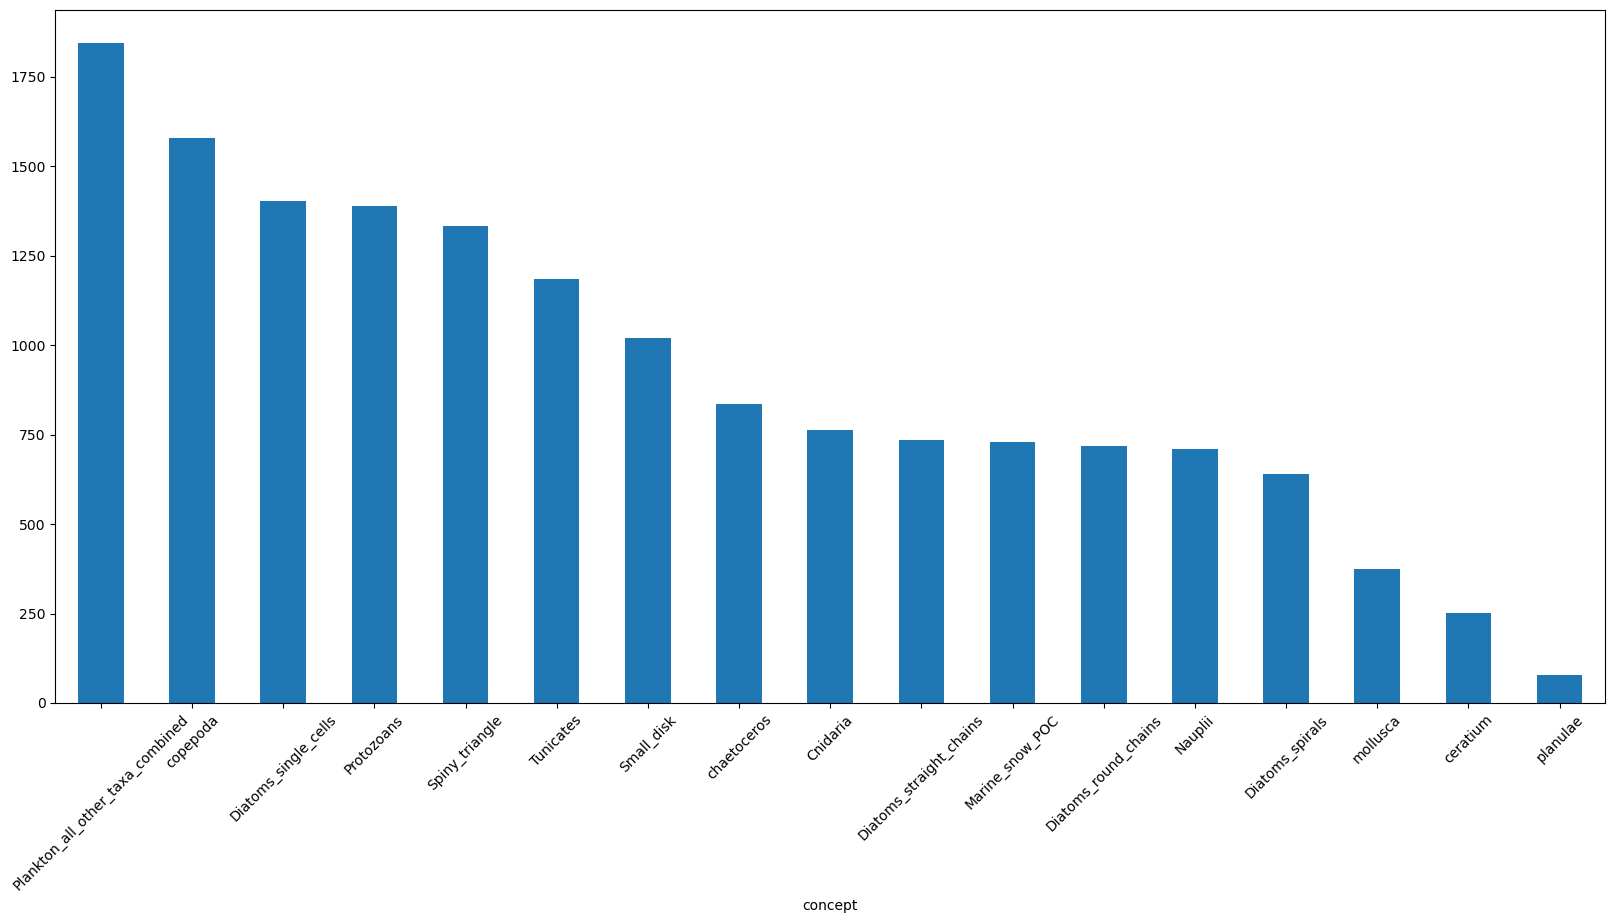

In [22]:
# plot counts
fig, ax = plt.subplots(figsize=(20,9))
df.groupby('concept')['aspect_ratio'].count().sort_values(ascending=False).plot.bar(ax=ax, rot=45)

### Major axis length

Make plots of distribution of major axis length in pixel units 

IndexError: list index out of range

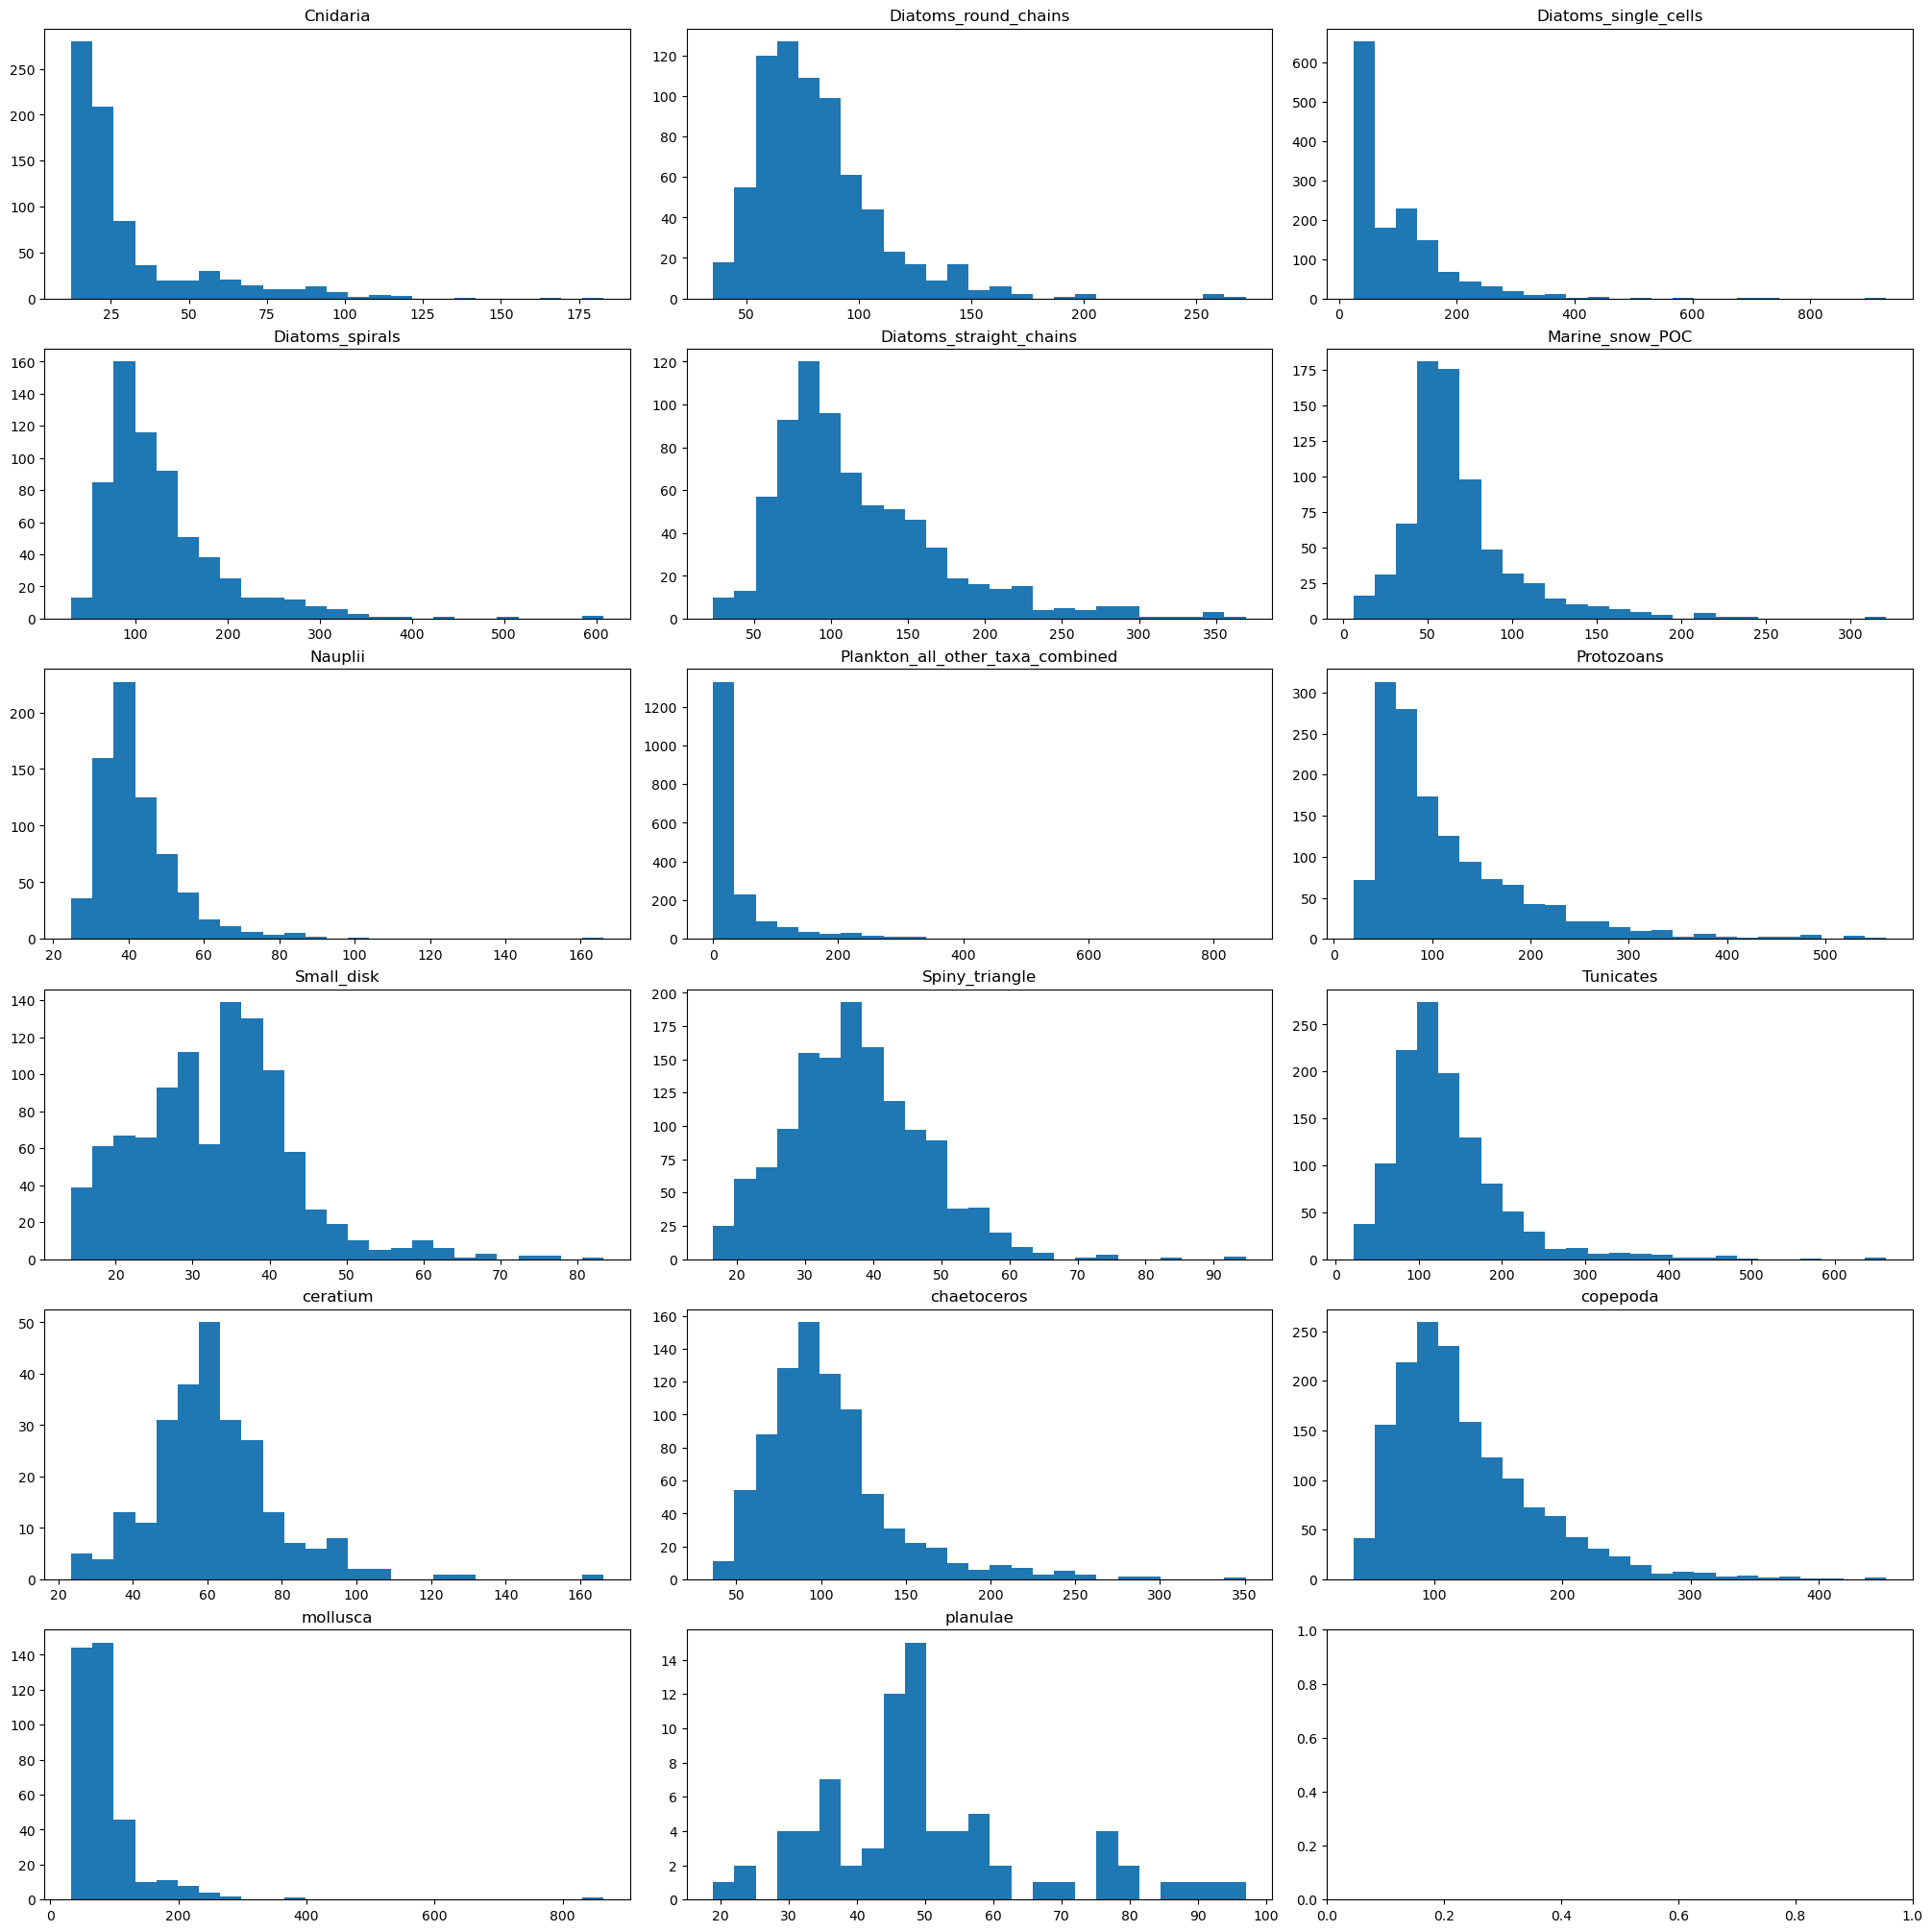

In [23]:
# subplots of major axis length
fig, axs = plt.subplots(6, 3, figsize=(20,20), constrained_layout=True)

axs = axs.flatten()
concepts = df.groupby('concept').count().index.to_list()

for ii in range(len(axs)):
    tmp = df[df['concept'] == concepts[ii]]['major_axis_length'].copy()
    tmp.plot(kind='hist', bins=25, ax=axs[ii])
    #axs[ii].set_ylim([0, 1350])
    axs[ii].set_ylabel('')
    axs[ii].set_title(concepts[ii])
    #axs[ii].set_xlim([-10, 1000])

fig.supxlabel('major axis length (px)')
fig.supylabel('frequency')

### Area

Make plots of area of each concept in pixel units.

IndexError: list index out of range

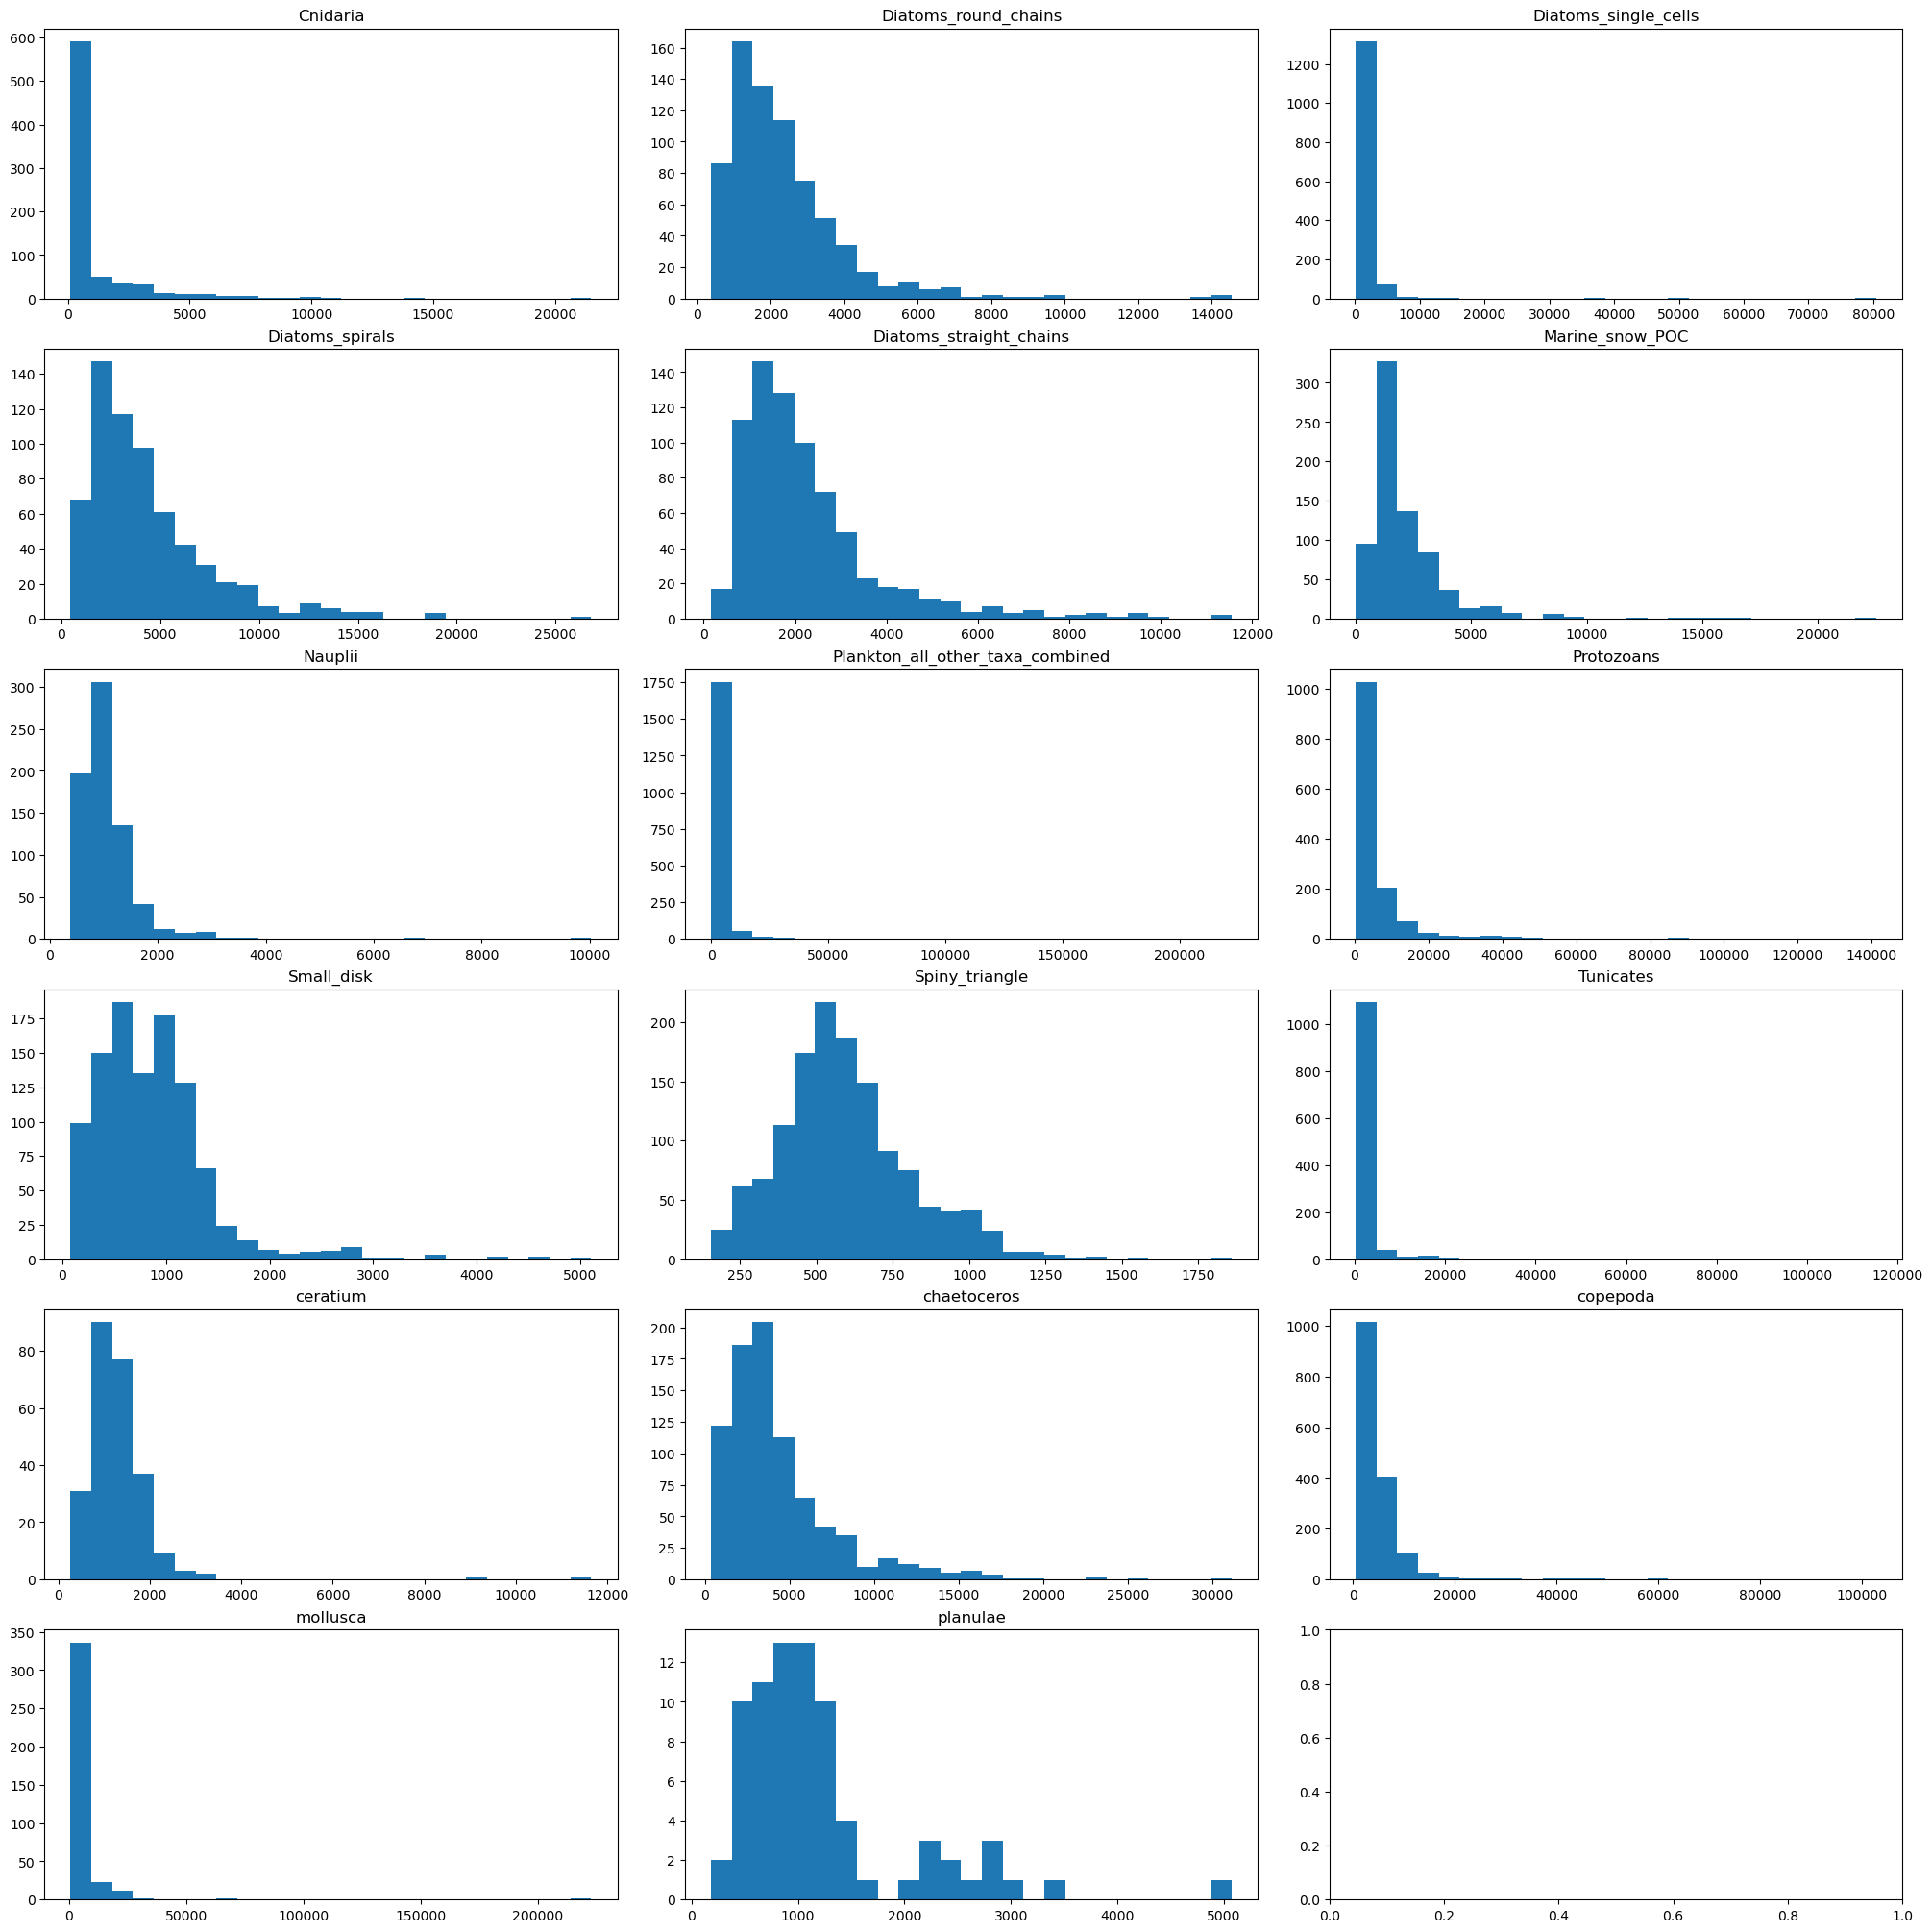

In [24]:
# subplots of area
fig, axs = plt.subplots(6, 3, figsize=(20,20), constrained_layout=True)


axs = axs.flatten()
concepts = df.groupby('concept').count().index.to_list()

for ii in range(len(axs)):
    tmp = df[df['concept'] == concepts[ii]]['area']  #.plot(kind='hist', bins=25, ax=axs[ii])
    # tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
    tmp.plot(kind='hist', bins=25, ax=axs[ii])
    #axs[ii].set_ylim([0, 1350])
    axs[ii].set_ylabel('')
    axs[ii].set_title(concepts[ii])
    #axs[ii].set_xlim([-10, 1000])

fig.supxlabel('area (px^2)')
fig.supylabel('frequency')

## Dates
Organize each concept by datetime